In this task we have to make classification between quarks and gluons

X (Features): Contains arrays representing jets. Each jet consists of M particles (with a maximum multiplicity). Each particle has the following features:

p_T (Transverse momentum): A measure of the particle’s momentum in the plane perpendicular to the beam.

Rapidity (y): A measure of the particle's velocity along the beam axis.

Azimuthal angle (ϕ): The angle of the particle in the transverse plane.

PDG ID: The Particle Data Group (PDG) identifier used to classify the particle.

y (Labels): Binary labels:

0: Gluon jet.
1: Quark jet.

In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Initialize the SGDClassifier and scaler globally
model = SGDClassifier(random_state=42, loss='log_loss')
scaler = StandardScaler()




I am using SGDClassifier model because it is better for classification problems and it also supports incremental learning. I had many list of .npz dataset files so i had to use this model to incrementally train model for each dataset.

I am also using standardscaler for data normalization -The StandardScaler is a preprocessing tool from the scikit-learn library used to standardize features by removing the mean and scaling them to unit variance. This process is also known as z-score normalization.


Randomforest model was taking too much time thats why i used this algorithm to save compute and time and not much difference in accuracy

In [35]:

def clean_and_extract_features(X):
    """
    Clean the 3D array and extract jet-level features.
    """
    num_jets = X.shape[0]  # Number of jets
    num_particles = X.shape[1]  # Maximum number of particles per jet

    # Initialize lists to store jet-level features
    jet_pT = []  # Sum of p_T of all particles in the jet
    multiplicity = []  # Number of particles in the jet
    mean_rapidity = []  # Mean rapidity of particles in the jet
    std_rapidity = []  # Standard deviation of rapidity
    mean_phi = []  # Mean azimuthal angle (phi)
    std_phi = []  # Standard deviation of phi

    for i in range(num_jets):
        # Extract particle-level features for the current jet
        p_T = X[i, :, 0]  # Transverse momentum
        rapidity = X[i, :, 1]  # Rapidity
        phi = X[i, :, 2]  # Azimuthal angle
        pdg_id = X[i, :, 3]  # PDG ID (particle type)

        # Remove padded values (particles with p_T = 0)
        mask = p_T > 0
        p_T = p_T[mask]
        rapidity = rapidity[mask]
        phi = phi[mask]
        pdg_id = pdg_id[mask]

        # Compute jet-level features
        jet_pT.append(np.sum(p_T))  # Sum of p_T
        multiplicity.append(len(p_T))  # Number of particles
        mean_rapidity.append(np.mean(rapidity))  # Mean rapidity
        std_rapidity.append(np.std(rapidity))  # Std rapidity
        mean_phi.append(np.mean(phi))  # Mean phi
        std_phi.append(np.std(phi))  # Std phi

        #Took help of chatgpt to write some of the codes, but i figured out pattern in data myself by multiple trials

    # Combine features into a DataFrame
    features = pd.DataFrame({
        'jet_pT': jet_pT,
        'multiplicity': multiplicity,
        'mean_rapidity': mean_rapidity,
        'std_rapidity': std_rapidity,
        'mean_phi': mean_phi,
        'std_phi': std_phi
    })
    return features

I have taken mean and standard deviation of the features of particles

In [38]:
def train_and_evaluate(file_path):
    """
    Load data from the .npz file, train the SGD Classifier incrementally, and evaluate the model.
    This function should be called after each file to retrain and evaluate the model.
    """
    # Load the .npz file
    data = np.load(file_path)
    X = data['X']  # Particle-level features
    y = data['y']  # Labels

    # Clean the data and extract features
    features = clean_and_extract_features(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

    # Normalize the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SGD model incrementally
    model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))  # Incremental training

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gluon', 'Quark'], yticklabels=['Gluon', 'Quark'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.68      0.73     10041
         1.0       0.71      0.82      0.76      9959

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.74     20000
weighted avg       0.75      0.75      0.74     20000

ROC-AUC Score: 0.7459884700661819


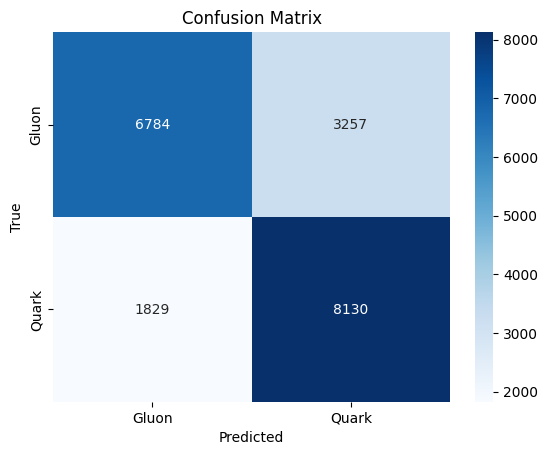

In [37]:
train_and_evaluate(r"C:\Users\sujal\Downloads\QG_jets_10.npz")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75     10152
         1.0       0.73      0.77      0.75      9848

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

ROC-AUC Score: 0.750449703899589


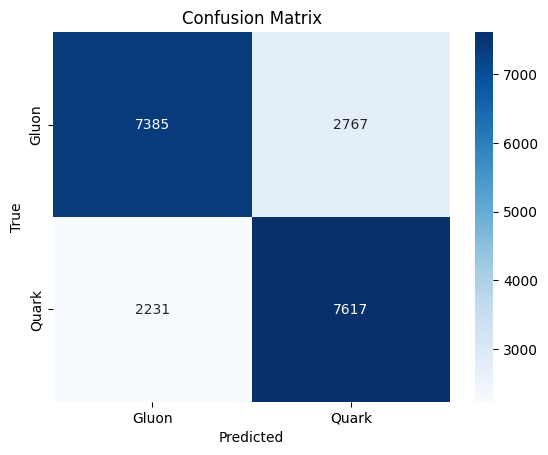

In [39]:
train_and_evaluate(r"C:\Users\sujal\Downloads\QG_jets_11.npz")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77      9956
         1.0       0.78      0.73      0.76     10044

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.76     20000
weighted avg       0.77      0.77      0.76     20000

ROC-AUC Score: 0.7652344949398221


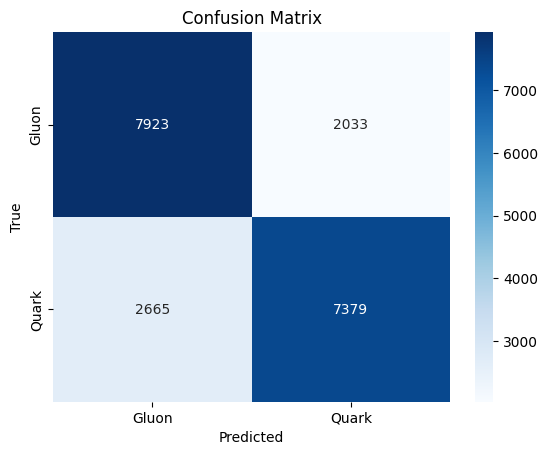

In [40]:
train_and_evaluate(r"C:\Users\sujal\Downloads\QG_jets_12.npz")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.74     10031
         1.0       0.73      0.78      0.75      9969

    accuracy                           0.74     20000
   macro avg       0.75      0.74      0.74     20000
weighted avg       0.75      0.74      0.74     20000

ROC-AUC Score: 0.744795817487806


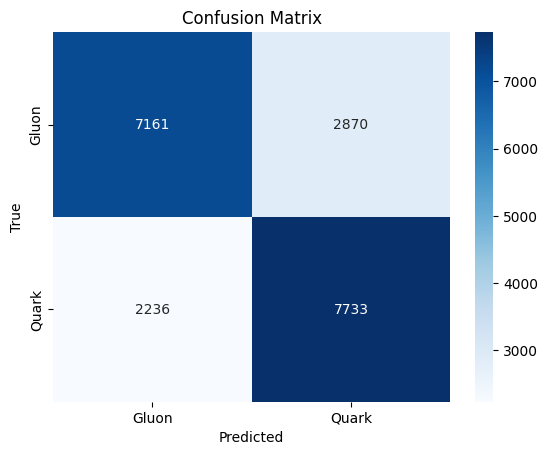

In [41]:
train_and_evaluate(r"C:\Users\sujal\Downloads\QG_jets_13.npz")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.75      9983
         1.0       0.74      0.80      0.77     10017

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

ROC-AUC Score: 0.7582716964052028


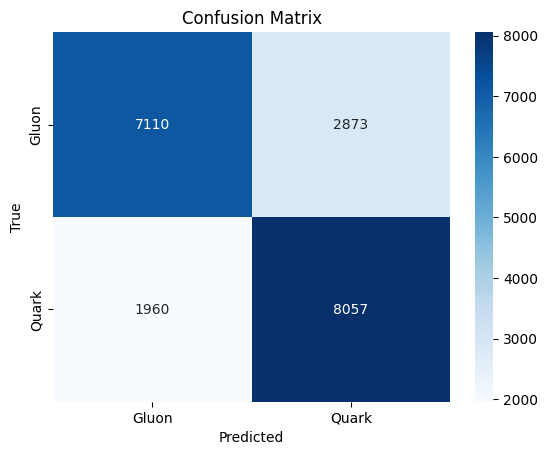

In [43]:
train_and_evaluate(r"C:\Users\sujal\Downloads\QG_jets_14.npz")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.70      0.74     10083
         1.0       0.73      0.82      0.77      9917

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

ROC-AUC Score: 0.7583292763038445


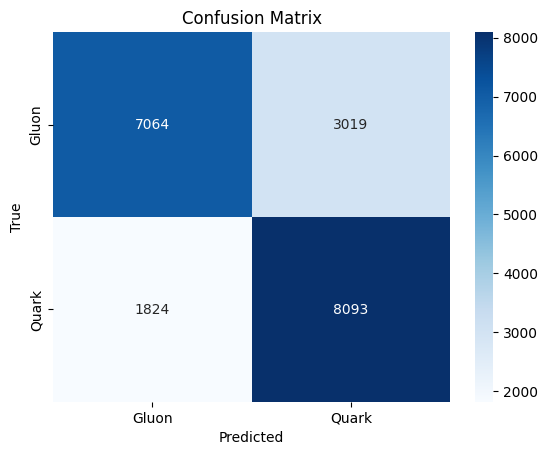

In [44]:
train_and_evaluate(r"C:\Users\sujal\Downloads\QG_jets_15.npz")